In [4]:
import os
import gc
from glob import glob
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import lightgbm as lgb
import torch
import torch.nn as nn

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings(action='ignore')

In [5]:
ROOT            = Path("/kaggle/input/home-credit-credit-risk-model-stability")
TRAIN_DIR       = ROOT / "parquet_files" / "train"
TEST_DIR        = ROOT / "parquet_files" / "test"

In [6]:
def reduce_mem_usage(df):
    """ 
    Source: Guillame Martin, 2018
    https://www.kaggle.com/code/gemartin/load-data-reduce-memory-usage
    
    
    Iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage. Necessary to manage RAM due to very large dataset
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


In [7]:
class Pipeline:
    """
    Source: Faruckan Saglam, 2024
    https://www.kaggle.com/code/greysky/home-credit-baseline
    
    Edits by: Julie Anne Co, 2024
    
    Data Preparation methods for the Home Credit Risk Model Stability dataset
    """
    
    @staticmethod
    def set_table_dtypes(df): 
        """
        Cast correct data types per column based on the column information embedded in the column names
        Last character of column name indicates transformation and data types
            * P - Transform DPD (Days past due)
            * M - Masking categories
            * A - Transform amount
            * D - Transform date
            * T - Unspecified Transform
            * L - Unspecified Transform

        """
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))            

        return df
    
    @staticmethod
    def handle_dates(df):
        """
        Transform date columns into numeric columns by subtracting it from 'date_decision' column
        """
        
        for col in df.columns:
            if (col[-1] in ("D",)) and ('count' not in col):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                
        df = df.drop("date_decision", "MONTH")

        return df
    
    @staticmethod
    def filter_cols(df): 
        """
        Remove Numeric columns with high perc_nulls (currently >0.95, modify to 0.97 to account for event rate)
        Remove Categorical columns with only 1 unique value or >50 unique values to control complexity
        Remove Numeric columns with no variance
        Remove Month, Year, or num_group columns
        """
        drop_cols = []
        print("Columns dropped due to high nulls:")
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()
                if isnull > 0.95:
                    print(col)
                    drop_cols.append(col)
                    df = df.drop(col)

        print("Categorical Columns dropped either due to no variance or high granularity")
        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM", ]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()

                if (freq == 1) | (freq > 50):
                    print(col)
                    drop_cols.append(col)
                    df = df.drop(col)
                    
            if (col[-1] not in ["P", "A", "L", "M"]) and (('month_' in col) or ('year_' in col)):
                drop_cols.append(col)
                df = df.drop(col)
        
        
        print("Numeric Columns dropped due to no variance")
        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM", ]) & (df[col].dtype in[pl.Int64, pl.Float64]):
                std = df[col].std()
                if std == 0:
                    print(col)
                    drop_cols.append(col)
                    df = df.drop(col)

        return df, drop_cols


In [8]:
class Aggregator:
    """
    Source: Faruckan Saglam, 2024
    https://www.kaggle.com/code/greysky/home-credit-baseline
    
    Edits by: Julie Anne Co, 2024
    
    Aggregation methods for the Home Credit Risk Model Stability dataset
    """
    
    @staticmethod
    def num_expr(df):
        """
        Max, min for all columns
        Mean, sum, std, sum for numeric columns
        """
        cols = [col for col in df.columns if (col[-1] in ("T","L","M","D","P","A")) or ("num_group" in col)]

        expr_1 = [pl.max(col).alias(f"max_{col}") for col in cols]
        expr_2 = [pl.min(col).alias(f"min_{col}") for col in cols]
        
        cols2 = [col for col in df.columns if col[-1] in ("L", "A")]
        expr_3 = [pl.mean(col).alias(f"mean_{col}") for col in cols2] + [pl.std(col).alias(f"std_{col}") for col in cols2] + \
            [pl.sum(col).alias(f"sum_{col}") for col in cols2] 
        
        return expr_1 + expr_2 + expr_3 
    
    @staticmethod
    def applprev2_exprs(df):
        """
        First values for applprev2 (previous applications) columns 
        """
        cols = [col for col in df.columns if "num_group" not in col]
        expr_2 = [pl.first(col).alias(f"first_{col}") for col in cols]
        return []
    

    @staticmethod
    def bureau_a1(df):
        """
        Min and Max for credit_bureau_a columns
        Mean, sum, first, std for specific columns
        """
        cols = [col for col in df.columns if (col[-1] in ("T","L","M","D","P","A")) or ("num_group" in col)]
        expr_1 = [pl.max(col).alias(f"max_{col}") for col in cols]
        expr_2 = [pl.min(col).alias(f"min_{col}") for col in cols]

        cols2 = [
        'annualeffectiverate_199L', 'annualeffectiverate_63L',
        'contractsum_5085717L', 
        'credlmt_230A', 'credlmt_935A',
       'nominalrate_281L', 'nominalrate_498L',
       'numberofcontrsvalue_258L', 'numberofcontrsvalue_358L',
       'numberofinstls_229L', 'numberofinstls_320L',
       'numberofoutstandinstls_520L', 'numberofoutstandinstls_59L',
       'numberofoverdueinstlmax_1039L', 'numberofoverdueinstlmax_1151L',
       'numberofoverdueinstls_725L', 'numberofoverdueinstls_834L'
       ]
        
        
        expr_3 = [pl.mean(col).alias(f"mean_{col}") for col in cols2] + [pl.std(col).alias(f"std_{col}") for col in cols2] + \
            [pl.sum(col).alias(f"sum_{col}") for col in cols2] +\
            [pl.first(col).alias(f"first_{col}") for col in cols2] 

        return expr_1 + expr_2 + expr_3    


    @staticmethod
    def bureau_b1(df):  
        return []
    
    
    @staticmethod
    def bureau_b2(df):
        
        return []


    @staticmethod
    def deposit_exprs(df):
        cols = [col for col in df.columns if (col[-1] in ("T","L","M","D","P","A")) or ("num_group" in col)]
        expr_1 = [pl.max(col).alias(f"max_{col}") for col in cols] + [pl.min(col).alias(f"min_{col}") for col in cols] # + \
        return expr_1 

    @staticmethod
    def debitcard_exprs(df):
        cols = [col for col in df.columns if (col[-1] in ("T","L","M","D","P","A")) or ("num_group" in col)]
        expr_1 = [pl.max(col).alias(f"max_{col}") for col in cols] + [pl.min(col).alias(f"min_{col}") for col in cols] 
        return expr_1


    @staticmethod
    def person_expr(df):
        cols1 = ['empl_employedtotal_800L', 'empl_employedfrom_271D', 'empl_industry_691L', 
                 'familystate_447L', 'incometype_1044T', 'sex_738L', 'housetype_905L', 'housingtype_772L',
                 'isreference_387L', 'birth_259D', ]
        expr_1 = [pl.first(col).alias(f"first_{col}") for col in cols1]
        
        expr_2 = [pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"), 
                  pl.col("mainoccupationinc_384A").filter(pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")]
        return expr_1 + expr_2 # + expr_4 # + expr_3
    
    @staticmethod
    def person_2_expr(df):
        cols = ['empls_economicalst_849M', 'empls_employedfrom_796D', 'empls_employer_name_740M'] # + \
        expr_1 = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_2 = [pl.last(col).alias(f"last_{col}") for col in cols]
        return expr_1 + expr_2

    @staticmethod
    def other_expr(df):
        expr_1 = [pl.first(col).alias(f"__other_{col}") for col in df.columns if ('num_group' not in col) and (col != 'case_id')]
        return expr_1 
    
    
    @staticmethod
    def tax_a_exprs(df):
        cols = [col for col in df.columns if (col[-1] in ("T","L","M","D","P","A")) or ("num_group" in col)]
        expr_1 = [pl.max(col).alias(f"max_{col}") for col in cols] + [pl.min(col).alias(f"min_{col}") for col in cols] + \
            [pl.last(col).alias(f"last_{col}") for col in cols] + \
            [pl.first(col).alias(f"first_{col}") for col in cols] + \
            [pl.mean(col).alias(f"mean_{col}") for col in cols] + \
            [pl.std(col).alias(f"std_{col}") for col in cols]
        expr_4 = [pl.col(col).fill_null(strategy="zero").apply(lambda x: x.max() - x.min()).alias(f"max-min_gap_depth2_{col}") for col in ['amount_4527230A']]

        return expr_1 + expr_4


    @staticmethod
    def bureau_a2(df):
        cols = [col for col in df.columns if (col[-1] in ("T","L","M","D","P","A")) or ("num_group" in col)]

        expr_1 = [pl.max(col).alias(f"max_depth2_{col}") for col in cols]
        expr_2 = [pl.min(col).alias(f"min_depth2_{col}") for col in cols]
        expr_3 = [pl.mean(col).alias(f"mean_depth2_{col}") for col in cols] + \
            [pl.std(col).alias(f"std_{col}") for col in cols]
        
        expr_4 = [pl.col(col).fill_null(strategy="zero").apply(lambda x: x.max() - x.min()).alias(f"max-min_gap_depth2_{col}") for col in ['collater_valueofguarantee_1124L', 'pmts_dpd_1073P', 'pmts_overdue_1140A',]]

        expr_ngc = [pl.count("num_group2").alias(f"count_depth2_a2_num_group2")]

        return expr_1 + expr_2 + expr_3 + expr_4 + expr_ngc
    
    @staticmethod
    def get_exprs(df):
        exprs = Aggregator.num_expr(df)

        return exprs


In [9]:
def agg_by_case(path, df):
    path = str(path)
    if '_applprev_1' in path:
        df = df.sort("num_group1").group_by("case_id").agg(Aggregator.get_exprs(df))
        
    elif '_credit_bureau_a_1' in path:
        df = df.sort("num_group1").group_by("case_id").agg(Aggregator.bureau_a1(df))

    elif '_credit_bureau_b_1' in path:
        df = df.sort("num_group1").group_by("case_id").agg(Aggregator.bureau_b1(df))

    elif '_deposit_1' in path:
        df = df.sort("num_group1").group_by("case_id").agg(Aggregator.deposit_exprs(df))
    elif '_debitcard_1' in path:
        df = df.sort("num_group1").group_by("case_id").agg(Aggregator.debitcard_exprs(df))
        
    elif '_tax_registry_a' in path:
        df = df.sort("num_group1").group_by("case_id").agg(Aggregator.tax_a_exprs(df))
    elif '_tax_registry_b' in path:
        df = df.sort("num_group1").group_by("case_id").agg(Aggregator.get_exprs(df))
    elif '_tax_registry_c' in path:
        df = df.sort("num_group1").group_by("case_id").agg(Aggregator.get_exprs(df))
        
    elif '_other_1' in path:
        df = df.sort("num_group1").group_by("case_id").agg(Aggregator.other_expr(df))
    elif '_person_1' in path:
        df = df.sort("num_group1").group_by("case_id").agg(Aggregator.person_expr(df))
    elif '_person_2' in path:
        df = df.group_by("case_id").agg(Aggregator.person_2_expr(df))

    elif '_credit_bureau_a_2' in path:
        df = df.group_by("case_id").agg(Aggregator.bureau_a2(df))
    elif '_credit_bureau_b_2' in path:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
    
    return df

def read_file(path, depth=None): 
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    
    if depth in [1, 2]:
        df = agg_by_case(path, df)
    
    print(f"{path}: {df.shape}")
    
    return df

def read_files(regex_path, depth=None):
    
    chunks = []
    for path in glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)
        if depth in [1, 2]:
            df = agg_by_case(path, df)
        chunks.append(df)
        
    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])
    
    print(f"{regex_path}: {df.shape}")
    
    return df

def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base.with_columns(
            decision_month = pl.col("date_decision").dt.month(),
            decision_weekday = pl.col("date_decision").dt.weekday(),
        )
    )
        
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
        
    df_base = df_base.pipe(Pipeline.handle_dates)
    return df_base

def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    print(df_data.info())
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    
    return df_data, cat_cols

def pd_to_polars(df):
    for col in df.columns:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if pd.api.types.is_integer_dtype(df[col].cat.categories.dtype):
                df[col] = df[col].astype(int)
            elif pd.api.types.is_float_dtype(df[col].cat.categories.dtype):
                df[col] = df[col].astype(float)

    return pl.from_pandas(df)

In [10]:
data_store = {
     "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
     "depth_0": [
         read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
         read_files(TRAIN_DIR / "train_static_0_*.parquet"),
        
     ],
     "depth_1": [
         read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
         read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
         read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
         read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
         read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
         read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
         read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
         read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
         read_file(TRAIN_DIR / "train_person_1.parquet", 1),
         read_file(TRAIN_DIR / "train_other_1.parquet", 1),
     ],
     "depth_2": [
         read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
         read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
         read_file(TRAIN_DIR / "train_person_2.parquet", 2),
     ]
 }

/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/train/train_base.parquet: (1526659, 5)
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/train/train_static_cb_0.parquet: (1500476, 53)
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/train/train_static_0_*.parquet: (1526659, 168)
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/train/train_applprev_1_*.parquet: (1221522, 150)
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/train/train_credit_bureau_a_1_*.parquet: (1386273, 225)
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/train/train_credit_bureau_b_1.parquet: (36500, 1)
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/train/train_deposit_1.parquet: (105111, 9)
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/train/train_debitcard_1.parquet: (111772, 11)
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/train/train

In [11]:
df_train = feature_eng(**data_store)
print("train data shape:\t", df_train.shape)

train data shape:	 (1526659, 774)


In [12]:
df_train, drop_col = df_train.pipe(Pipeline.filter_cols)
print("train data shape:\t", df_train.shape)

Columns dropped due to high nulls:
assignmentdate_4955616D
dateofbirth_342D
for3years_128L
for3years_504L
for3years_584L
formonth_118L
formonth_206L
formonth_535L
forquarter_1017L
forquarter_462L
forquarter_634L
fortoday_1092L
forweek_1077L
forweek_528L
forweek_601L
foryear_618L
foryear_818L
foryear_850L
pmtaverage_4955615A
pmtcount_4955617L
riskassesment_302T
riskassesment_940T
clientscnt_136L
equalityempfrom_62L
interestrategrace_34L
isbidproductrequest_292L
lastdependentsnum_448L
lastotherinc_902A
lastotherlnsexpense_631A
lastrepayingdate_696D
maxannuity_4075009A
payvacationpostpone_4187118D
mean_credacc_status_367L
mean_credtype_587L
mean_familystate_726L
mean_inittransactioncode_279L
mean_status_219L
std_credacc_actualbalance_314A
std_credacc_maxhisbal_375A
std_credacc_minhisbal_90A
std_credacc_status_367L
std_credacc_transactions_402L
std_credtype_587L
std_familystate_726L
std_inittransactioncode_279L
std_revolvingaccount_394A
std_status_219L
sum_credacc_status_367L
sum_credtype_

In [13]:
del data_store
gc.collect()

0

In [14]:
def root_col(x):
    """
    Get root information by removing prefixes
    """
    split = x.split('_')
    if split[0] in ['min', 'max', 'mean', 'var', 'mode', 'first', 'last', 'std', 'count']:
        return '_'.join(split[1:])
    return x

In [15]:
features = pd.read_csv(ROOT/'feature_definitions.csv')
drop_col = pd.DataFrame(drop_col, columns = ['Features'] )
drop_col['root_col'] = drop_col['Features'].apply(lambda x: root_col(x))
drop_col = drop_col.merge(features, left_on = 'root_col', right_on = 'Variable', how = 'left')
drop_col['main_info'] = drop_col['root_col'].apply(lambda x: "_".join(x.split("_")[:-1]))

In [16]:
drop_col.head(10)

,Features,root_col,Variable,Description,main_info
0,assignmentdate_4955616D,assignmentdate_4955616D,assignmentdate_4955616D,Tax authority assignment date.,assignmentdate
1,dateofbirth_342D,dateofbirth_342D,dateofbirth_342D,Client's date of birth.,dateofbirth
2,for3years_128L,for3years_128L,for3years_128L,Number of rejected applications in the past 3 ...,for3years
3,for3years_504L,for3years_504L,for3years_504L,Client's credit history data over the last thr...,for3years
4,for3years_584L,for3years_584L,for3years_584L,Number of cancellations in the last 3 years.,for3years
5,formonth_118L,formonth_118L,formonth_118L,Number of rejections in a month.,formonth
6,formonth_206L,formonth_206L,formonth_206L,Number of cancelations in the previous month.,formonth
7,formonth_535L,formonth_535L,formonth_535L,Credit history for the last month.,formonth
8,forquarter_1017L,forquarter_1017L,forquarter_1017L,Number of cancellations recorded in the credit...,forquarter
9,forquarter_462L,forquarter_462L,forquarter_462L,Number of credit applications that were reject...,forquarter


In [51]:
[col for col in df_train.columns if 'last30dayturnover' in col]

[]

In [48]:
[col for col in df_train.columns if 'depth2_pmts_month' in col]

[]

At a threshold of 95% null, 178 of 774 columns were dropped. Inspecting the dropped columns, multiple versions of columns exist for one type of information although there are versions retained in the training table.

### Feature Selection

In [15]:
class Feature_Selector:
    """
    Created by: Julie Anne Co, 2024
    
    Helper methods for feature selection. 
    Generation of stats, Data Type Transformers, Mann Whitney U Test, 
    Chi Square Test, Anova F-Value, Pearson Correlation
    Correlation-based Feature Deletion
    """
    @staticmethod
    def stats_generator(df):
        """
        Generate summary statistics
        """
        stats = pd.DataFrame(df.describe(include = 'all')).T.reset_index()
        stats = stats.rename(columns = {'index': 'columns'})
        stats.insert(1, 'dtype', list(stats['columns'].apply(lambda x: df[x].dtype)))
        stats['nunique'] = stats['columns'].apply(lambda x: df_train[x].nunique())
        stats['perc_null'] = 1 - stats['count']/stats['count'].max()
        stats = stats.drop(['unique', 'freq', 'top'], axis = 1)
        for col in ['mean', 'std', 'min', '25%', '50%', '75%', 'max', 'perc_null']:
            stats[col] = pd.to_numeric(stats[col], errors = 'coerce')
        
        return stats
    
    @staticmethod
    def transform_category(df, cat_cols = None):
        """
        Transform 'object' column types to 'category'
        Useful for LightGBM categorical inputs
        """
        if cat_cols is None:
            cat_cols = list(df.select_dtypes("object").columns)
    
        df[cat_cols] = df[cat_cols].astype("category")
        cat_cols = df.select_dtypes("category").columns
        return df, cat_cols
    
    @staticmethod
    def cat_to_string(df, cat_cols = None):
        """
        Transform 'category' columns to 'string'
        Useful for CatBoost categorical inputs
        """
        if cat_cols is None:
            cat_cols = list(df.select_dtypes("category").columns)
    
        df[cat_cols] = df[cat_cols].astype("object")
        cat_cols = df.select_dtypes("object").columns
        return df, cat_cols
    
    @staticmethod
    def mann_whitney_test(df, col, target, alpha = 0.05):
        """
        Checks if two samples (non-target vs target) come from the same distribution
        Checking dependence of a column to target variable
        Default alpha: 0.05
        """
        from scipy.stats import mannwhitneyu
        
        if df[col].dtypes not in ['int64', 'float64'] and col != target:
            return None
        
        sample1 = df[df[target] == 0][col]
        sample2 = df[df[target] == 1][col]
        
        statistic, p_value = mannwhitneyu(sample1, sample2)
        
        return p_value
        
    @staticmethod
    def chi_square(df, target_col, column):
        """
        Returns the chi-square p-value for each column in the DataFrame
        compared to the target column.

        Requires target and subject column to be categorical/binary

        """
        
        from scipy.stats import chi2_contingency
    
        if df[column].dtypes != 'category' or column == target_col or df[column].nunique() > 50:
            return None

        contingency = pd.crosstab(df[column], df[target_col])
        chi2, p_value, _, _ = chi2_contingency(contingency)

        return p_value
    
    @staticmethod
    def anova_f(df, target, col, impute = None):
        from sklearn.feature_selection import f_classif
        
        if df[col].dtypes not in ['int64', 'float64']:
            return None
        
        if col in ['case_id', 'target', 'WEEK_NUM', 'decision_month', 'decision_weekday']:
            return None
        
        df = df[[col, target]]
        
        if impute is None:
            df = df.dropna(subset=[col])
            if len(df[target].unique()) < 2:
                return None
        
        elif impute == 'mean':
            df[col] = df.fillna(df[col].mean())
        
        elif impute == 'median':
            df[col] = df.fillna(df[col].median())
            
        elif impute == 'zero':
            df[col] = df.fillna(0)
            
        elif impute.isnumeric():
            df[col] = df.fillna(eval(impute))
        
        f_statistic, p_val = f_classif(df[col].to_numpy().reshape(-1,1), df[target].to_numpy())
        return p_val[0]
    
    @staticmethod
    def pearson_corr(df, target, col):
        """
        Returns correlation of 2 variables
        """
        if target != col and df[col].dtype in ['int64', 'float64']:
            return df[target].corr(df[col])
        return None
    
    @staticmethod
    def num_cols(df, exclude):
        """
        Returns list of numeric columns
        """
        num_cols = [col for col, dtype in df.dtypes.items() if col not in exclude and dtype in ['int64', 'float64']]
        return num_cols
    
    @staticmethod
    def correl_del(df, stats, threshold = 0.9):
        """
        Returns columns to drop based on 
        """
        stats['corr'] = stats['corr'].apply(lambda x: np.abs(x))
        stats = stats.sort_values(by = ['columns', 'corr', 'anova_dropna', 'perc_null', 'std'],
                                  ascending = [True, False, True, True, False])
        drop_cols = []
        
        for col in df.columns:
            if col not in drop_cols:
                cols = [x for x in df.columns if x != 'target']
                corr = df[cols].corrwith(df[col])
                high_corr = corr[np.abs(corr) > threshold].index
                if high_corr > 1:
                    drop = list(stats[stats['columns'].isin(high_corr)]['columns'][1:])
                    print(f"{col} -> Drop: {drop}")
                    drop_cols.append(drop)
            else:
                print(f"{col}: Dropped")
                               
        return drop_cols

In [17]:
df_train = df_train.to_pandas()

In [18]:
df_train, cat_cols = Feature_Selector.transform_category(df_train)

In [19]:
df_train.head()

,case_id,WEEK_NUM,target,decision_month,decision_weekday,assignmentdate_238D,assignmentdate_4527235D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,...,std_pmts_overdue_1140A,std_pmts_overdue_1152A,max-min_gap_depth2_collater_valueofguarantee_1124L,max-min_gap_depth2_pmts_dpd_1073P,max-min_gap_depth2_pmts_overdue_1140A,count_depth2_a2_num_group2,first_empls_economicalst_849M,first_empls_employer_name_740M,last_empls_economicalst_849M,last_empls_employer_name_740M
0,0,0,0,1,4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,0,1,4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,0,1,5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,0,1,4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,1,1,5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
pd.DataFrame(df_train.dtypes).to_csv('data_schema.csv')

In [17]:
stats = Feature_Selector.stats_generator(df_train)
stats['chi_p'] = stats['columns'].apply(lambda x: Feature_Selector.chi_square(df_train, 'target', x))
stats['anova_dropna'] = stats['columns'].apply(lambda x: Feature_Selector.anova_f(df_train, 'target', x))
stats['corr'] = stats['columns'].apply(lambda x: Feature_Selector.pearson_corr(df_train, 'target', x))
stats

,columns,dtype,count,mean,std,min,25%,50%,75%,max,nunique,perc_null,chi_p,anova_dropna,corr
0,case_id,int64,1526659.0,1.286077e+06,718946.592285,0.0,766197.5,1357358.0,1739022.5,2703454.0,1526659,0.000000,NaN,NaN,0.003834
1,WEEK_NUM,int64,1526659.0,4.076904e+01,23.797981,0.0,23.0,40.0,55.0,91.0,92,0.000000,NaN,NaN,0.002969
2,target,int64,1526659.0,3.143728e-02,0.174496,0.0,0.0,0.0,0.0,1.0,2,0.000000,NaN,NaN,NaN
3,decision_month,int8,1526659.0,6.425584e+00,3.512803,1.0,3.0,7.0,9.0,12.0,12,0.000000,NaN,NaN,NaN
4,decision_weekday,int8,1526659.0,3.984014e+00,1.988480,1.0,2.0,4.0,6.0,7.0,7,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,count_depth2_a2_num_group2,float64,1385288.0,1.359273e+02,129.050030,1.0,48.0,96.0,180.0,9404.0,338,0.092602,NaN,1.314952e-207,-0.026120
592,first_empls_economicalst_849M,category,1435105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,0.059970,0.005286,NaN,NaN
593,first_empls_employer_name_740M,category,1435105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0.059970,1.000000,NaN,NaN
594,last_empls_economicalst_849M,category,1435105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,0.059970,0.863548,NaN,NaN


In [18]:
stats.to_csv('stats.csv')

In [19]:
num_cols = Feature_Selector.num_cols(df_train, ['case_id', 'WEEK_NUM', 'target', 'decision_month', 'decision_weekday'])
len(num_cols)

509

Log of all columns deleted due to highly correlated variables

In [20]:
gc.collect()
stats['abs_corr'] = stats['corr'].apply(lambda x: np.abs(x))
stats = stats.sort_values(by = ['abs_corr', 'anova_dropna', 'perc_null', 'std'],
                                  ascending = [False, True, True, False])
drop_cols = []
        
for i, col in enumerate(num_cols):
    if col not in drop_cols:
        cols = [x for x in num_cols if x != 'target']
        corr = df_train[cols].corrwith(df_train[col])
        high_corr = corr[np.abs(corr) > 0.9].index
        #if len(high_corr) > 1:
        if len(high_corr) > 2:
            drop = list(stats[stats['columns'].isin(high_corr)]['columns'][2:])
            drop = [x for x in drop if x not in drop_cols]
            drop_cols.extend(drop)
            print(f"{i}: {col} -> Drop: {drop}, {len(drop_cols)} cols to drop")
        else:
            print(f"{i}: {col} -> No High Corr, {len(drop_cols)} cols to drop")
    else:
        print(f"{i}: {col} -> Already Dropped, {len(drop_cols)} cols to drop")

del cols
del corr
del high_corr
del drop
gc.collect()

0: assignmentdate_238D -> No High Corr, 0 cols to drop
1: assignmentdate_4527235D -> No High Corr, 0 cols to drop
2: birthdate_574D -> Drop: ['dateofbirth_337D'], 1 cols to drop
3: contractssum_5085716L -> Drop: ['max_contractsum_5085717L'], 2 cols to drop
4: dateofbirth_337D -> Already Dropped, 2 cols to drop
5: days120_123L -> Drop: ['days90_310L'], 3 cols to drop
6: days180_256L -> No High Corr, 3 cols to drop
7: days30_165L -> No High Corr, 3 cols to drop
8: days360_512L -> No High Corr, 3 cols to drop
9: days90_310L -> Already Dropped, 3 cols to drop
10: firstquarter_103L -> No High Corr, 3 cols to drop
11: fourthquarter_440L -> No High Corr, 3 cols to drop
12: numberofqueries_373L -> No High Corr, 3 cols to drop
13: pmtaverage_3A -> No High Corr, 3 cols to drop
14: pmtaverage_4527227A -> No High Corr, 3 cols to drop
15: pmtcount_4527229L -> No High Corr, 3 cols to drop
16: pmtcount_693L -> Drop: ['mean_num_group1', 'pmtscount_423L', 'std_num_group1', 'max_num_group1_9', 'pmtcount

0

In [28]:
import pickle
with open('drop_num_cols_top2.pkl', 'wb') as f:
    pickle.dump(drop_cols, f)

In [22]:
df_train = reduce_mem_usage(df_train)

Memory usage of dataframe is 6085.83 MB
Memory usage after optimization is: 2205.77 MB
Decreased by 63.8%


In [23]:
keep_cols = [x for x in df_train.columns if x not in drop_cols]
len(keep_cols)

455

In [24]:
len(num_cols) - len(drop_cols)

368

Quick Check:
- Nulls Capped at 95%
- Categorical columns with uniqe values capped at 50


0.00    0.000000
0.25    0.152682
0.50    0.296460
0.75    0.550644
1.00    0.948890
Name: perc_null, dtype: float64


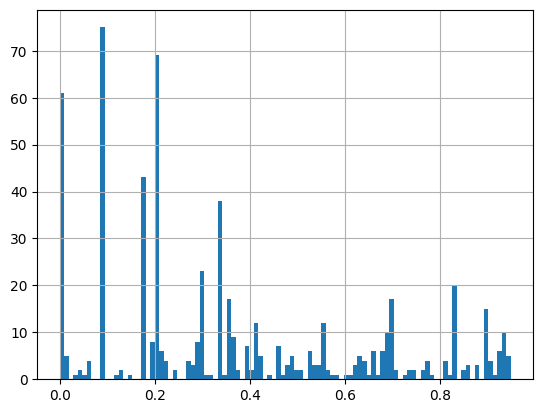

In [18]:
print(stats['perc_null'].quantile([0, 0.25, 0.5, 0.75, 1]))
stats['perc_null'].hist(bins = 100);

In [22]:
stats.to_csv('stats.csv')

0.00     1.0
0.25     3.0
0.50     5.0
0.75     9.0
1.00    45.0
Name: nunique, dtype: float64


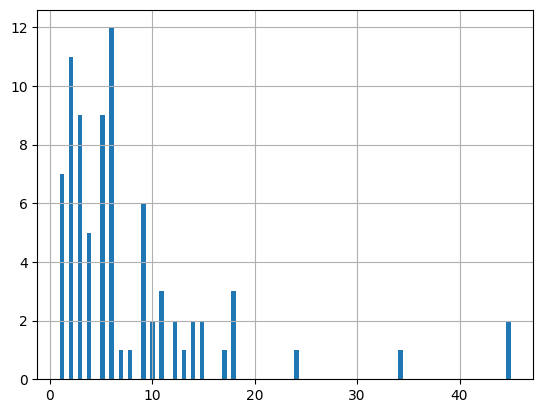

In [23]:
print(stats[stats['dtype'] == 'object']['nunique'].quantile([0, 0.25, 0.5, 0.75, 1]))
stats[stats['dtype'] == 'object']['nunique'].hist(bins = 100);

0.00    0.000000
0.25    0.172044
0.50    0.296460
0.75    0.540480
1.00    0.948890
Name: perc_null, dtype: float64


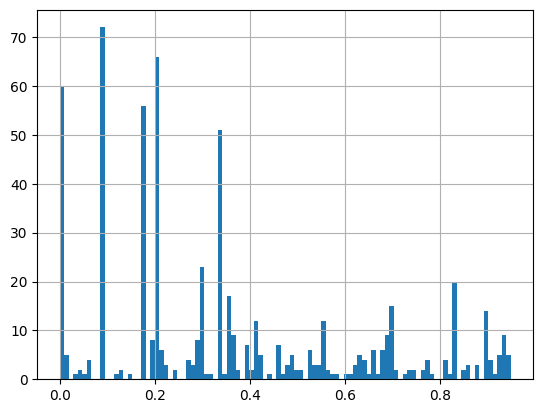

In [25]:
print(stats['perc_null'].quantile([0, 0.25, 0.5, 0.75, 1]))
stats['perc_null'].hist(bins = 100);

In [27]:
df_train = df_train[list(stats['columns'])]

In [28]:
id_cols = ['case_id', 'WEEK_NUM', 'target', 'decision_month', 'decision_weekday']
feature_cols = [x for x in stats['columns'] if x not in id_cols]
num_cols = [x for x in stats[stats['dtype']!='object']['columns'] if x not in id_cols]

In [52]:
#drop_cols = num_col_red1 + num_col_red2 + num_col_red3 + drop_cols_comb
keep_cols = [x for x in num_cols if x not in drop_cols]
len(keep_cols)

313

In [53]:
import pickle
with open('drop_cols.pkl', 'wb') as f:
    pickle.dump(drop_cols, f)

In [71]:
df_train = df_train.merge(target[['case_id', 'target']], on = 'case_id', how = 'left')

In [25]:
keep_cols = [x for x in df_train.columns if x not in drop_cols]

In [26]:
df_train,cat_cols = Feature_Selector.cat_to_string(df_train)

In [27]:
pl.from_pandas(df_train[keep_cols]).write_csv('model_abt_pl_corr2_drop.csv')

In [66]:
pd_to_polars(df_train.drop(drop_cols, axis = 1)).write_csv('model_abt_pl_corr_drop.csv')